In [4]:
import torch
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Select device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.nn as nn

class DrivingModel(nn.Module):
    def __init__(self):
        super(DrivingModel, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),  # [3, 224, 224] -> [24, 110, 110]
            nn.ReLU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2), # [24, 110, 110] -> [36, 53, 53]
            nn.ReLU(),
            nn.Conv2d(36, 64, kernel_size=3, stride=1), # [36, 53, 53] -> [64, 51, 51]
            nn.ReLU(),
            nn.Flatten()                                # Flatten to [64 * 51 * 51 = 166464]
        )

        self.fc = nn.Sequential(
            nn.Linear(166464, 100),
            nn.ReLU(),
            nn.Linear(100, 3)  # Output: [steering, throttle, brake]
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x



# Instantiate and load the model weights
model = DrivingModel().to(device)
weights_path = "C:/Users/TANMAY/OneDrive/Desktop/Major project self driving/New/driving_model.pth"  # placeholder path
state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()  # set model to evaluation mode


DrivingModel(
  (cnn): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(36, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=166464, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [5]:
model = DrivingModel().to(device)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()


DrivingModel(
  (cnn): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(36, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=166464, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [10]:
# Define preprocessing: resize to 224x224, convert to tensor, normalize with ImageNet stats
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # resize image
    transforms.ToTensor(),          # convert PIL image to PyTorch tensor [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std =[0.229, 0.224, 0.225])  # ImageNet mean/std:contentReference[oaicite:2]{index=2}
])

# Load the test image
image_path = "C:/Users/TANMAY/OneDrive/Desktop/Major project self driving/New/dataset/images/frame_00000.png"  # placeholder path
original_image = Image.open(image_path).convert("RGB")


In [11]:
# Brightness adjustment
def adjust_brightness(img, factor=1.5):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor)

# Gaussian noise addition
def add_gaussian_noise(img, mean=0, std=0.1):
    arr = np.array(img).astype(np.float32) / 255.0
    noise = np.random.normal(mean, std, arr.shape)
    arr_noisy = np.clip(arr + noise, 0, 1.0)
    noisy_img = Image.fromarray((arr_noisy * 255).astype(np.uint8))
    return noisy_img

# Gaussian blur
def apply_blur(img, radius=2):
    return img.filter(ImageFilter.GaussianBlur(radius=radius))

# Fog (blend with white)
def add_fog(img, intensity=0.5):
    fog_layer = Image.new('RGB', img.size, (255, 255, 255))
    return Image.blend(img, fog_layer, alpha=intensity)

# Rain effect (draw random lines)
import random
def add_rain(img, num_drops=1000):
    rain_img = img.copy()
    draw = ImageDraw.Draw(rain_img)
    width, height = rain_img.size
    for _ in range(num_drops):
        x = random.randint(0, width)
        y = random.randint(0, height)
        length = random.randint(10, 20)
        x_end = x + random.randint(-5, 5)
        y_end = y + length
        draw.line([(x, y), (x_end, y_end)], fill=(200, 200, 200), width=1)
    return rain_img

# Night (grayscale + darken)
def make_night(img, dark_factor=0.3):
    gray = img.convert('L').convert('RGB')  # convert to grayscale (as RGB)
    enhancer = ImageEnhance.Brightness(gray)
    return enhancer.enhance(dark_factor)

# Occlusion (black rectangle in center)
def add_occlusion(img, box_frac=0.5):
    occ_img = img.copy()
    draw = ImageDraw.Draw(occ_img)
    w, h = occ_img.size
    # define central rectangle (e.g., central 50% of image)
    x0, y0 = w*(1-box_frac)/2, h*(1-box_frac)/2
    x1, y1 = w*(1+box_frac)/2, h*(1+box_frac)/2
    draw.rectangle([x0, y0, x1, y1], fill=(0, 0, 0))
    return occ_img


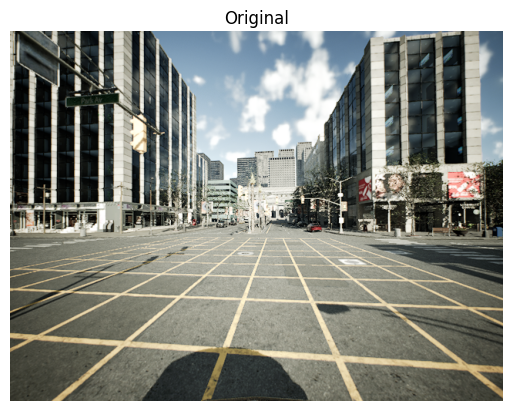

Original output (steering, throttle, brake): [-0.3604976534843445, 0.777021586894989, 0.05437278002500534]


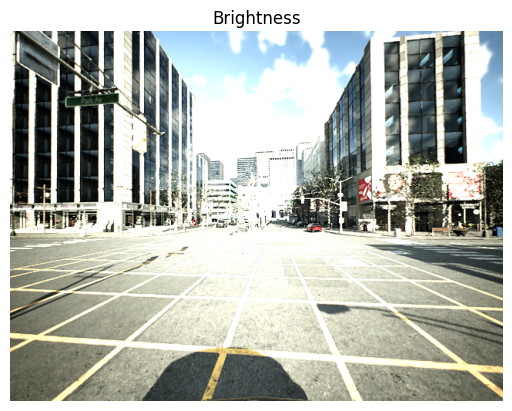

Brightness output (steering, throttle, brake): [-0.34737348556518555, 0.1875009387731552, 0.5679128766059875]


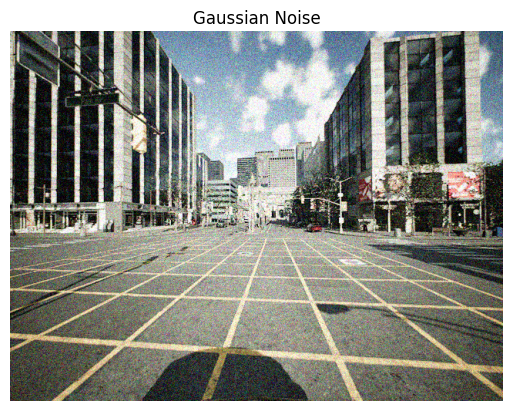

Gaussian Noise output (steering, throttle, brake): [-0.3505140542984009, 0.7742331624031067, 0.05553290992975235]


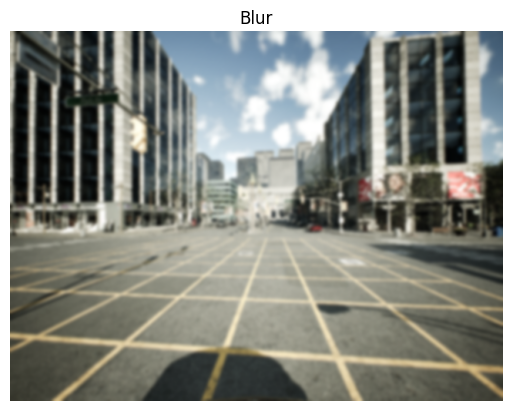

Blur output (steering, throttle, brake): [-0.3489738702774048, 0.7382055521011353, 0.05354567617177963]


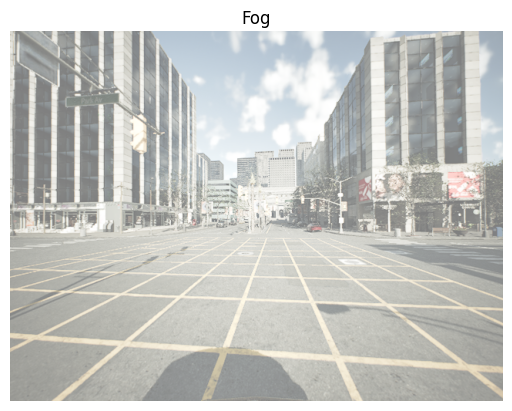

Fog output (steering, throttle, brake): [-0.17111724615097046, -0.004160270094871521, 0.19441640377044678]


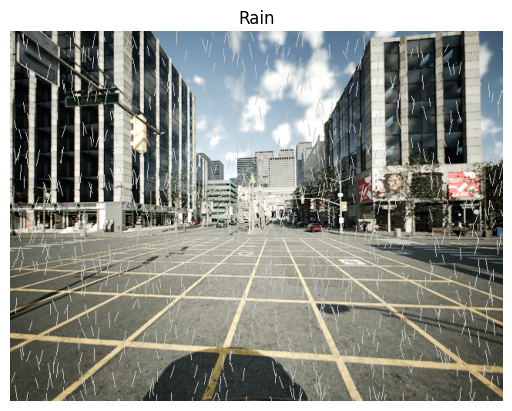

Rain output (steering, throttle, brake): [-0.3573295474052429, 0.7771915197372437, 0.057672254741191864]


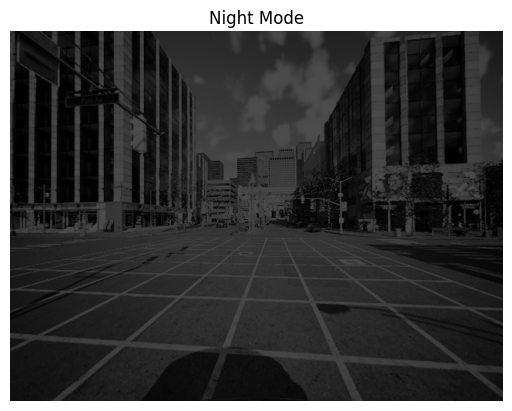

Night Mode output (steering, throttle, brake): [-0.04600750282406807, 0.023225344717502594, 0.057563986629247665]


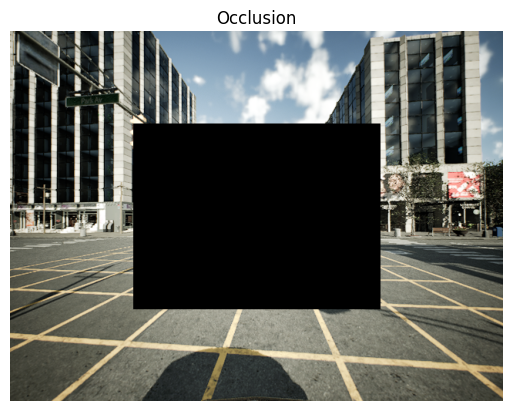

Occlusion output (steering, throttle, brake): [-0.2697656750679016, 0.5405843257904053, 0.12506935000419617]


In [12]:
# List of (name, perturbed_image) pairs
perturbed_images = [
    ("Original", original_image),
    ("Brightness", adjust_brightness(original_image, factor=1.5)),
    ("Gaussian Noise", add_gaussian_noise(original_image, mean=0, std=0.1)),
    ("Blur", apply_blur(original_image, radius=2)),
    ("Fog", add_fog(original_image, intensity=0.5)),
    ("Rain", add_rain(original_image, num_drops=800)),
    ("Night Mode", make_night(original_image, dark_factor=0.3)),
    ("Occlusion", add_occlusion(original_image, box_frac=0.5))
]

# Iterate and display images
for name, img in perturbed_images:
    # Display the perturbed image
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')
    plt.show()

    # Preprocess and run inference
    input_tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
    output_list = output.squeeze().cpu().tolist()
    print(f"{name} output (steering, throttle, brake): {output_list}")
